In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from general_class_balancer import *

In [2]:
def save_ids(ids, path_out, case,fold=None):
    tag = f'{case}.txt' if fold is None else f'{case}_test_set_{fold}.txt'
    filename = os.path.join(path_out,tag)
    with open(filename, 'w') as file:
        for i in ids:
            file.write(f"{i}\n")

## Load data

In [11]:
p_pheno = '/home/harveyaa/Documents/fMRI/data/ukbb_9cohorts/pheno_26-01-22.csv'
p_ids = '/home/harveyaa/Documents/masters/MTL/conf_balancing/dataset_ids'
p_out = '/home/harveyaa/Documents/masters/MTL/conf_balancing/dataset_ids_temp'

pheno = pd.read_csv(p_pheno,index_col=0)

conf = ['AGE',
        'SEX',
        'SITE',
        'mean_conn',
        'FD_scrubbed']

/home/harveyaa/miniconda3/envs/MTL/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (7,8,12,13,14,19,20,24,27,31,42,43,44,49,51,59,60,62,64,65,68,101,121,163) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
cases = ['SZ',
        'ASD',
        'BIP',
        'DEL22q11_2',
        'DUP22q11_2',
        'DEL16p11_2',
        'DUP16p11_2',
        'DEL1q21_1',
        'DUP1q21_1']

ipc = ['SZ',
        'ASD',
        'BIP']

## Load datasets

In [5]:
sel_ids = []
for case in cases:
    df = pd.read_csv(os.path.join(p_ids,f"{case}.txt"),header=None)
    sel_ids.append(df)
sel_ids = dict(zip(cases,sel_ids))

## Check datasets
Expect unbalanced for IPC & DEL22q11_2

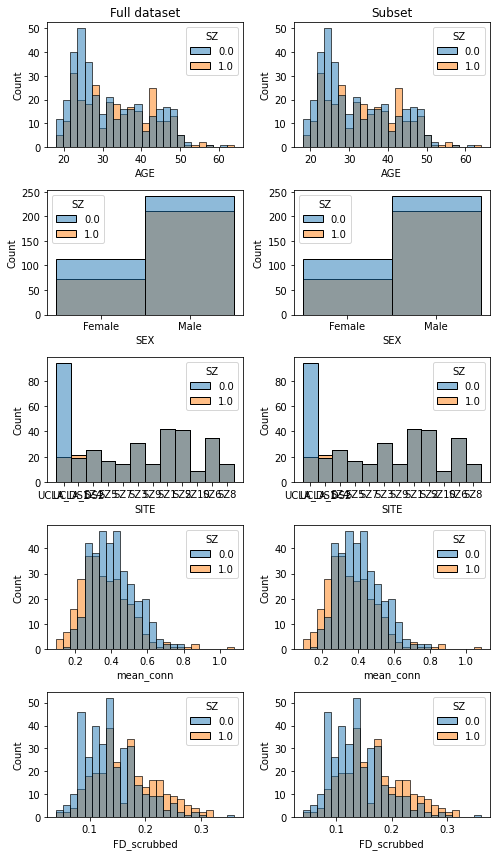

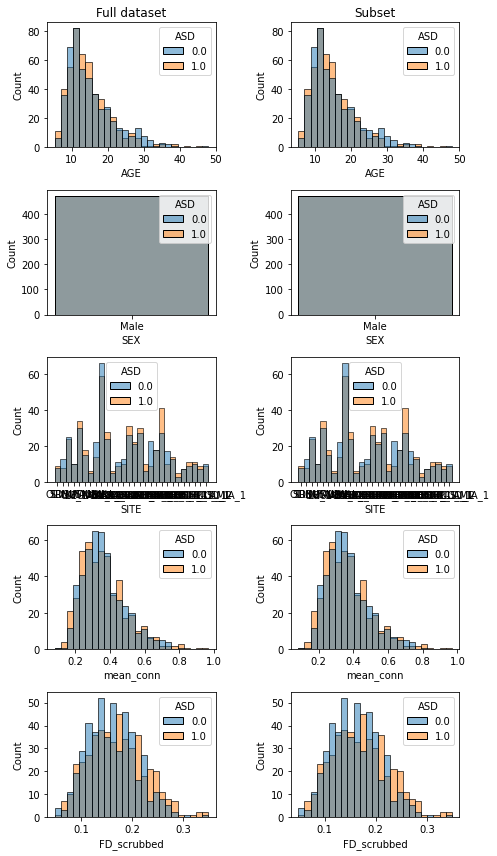

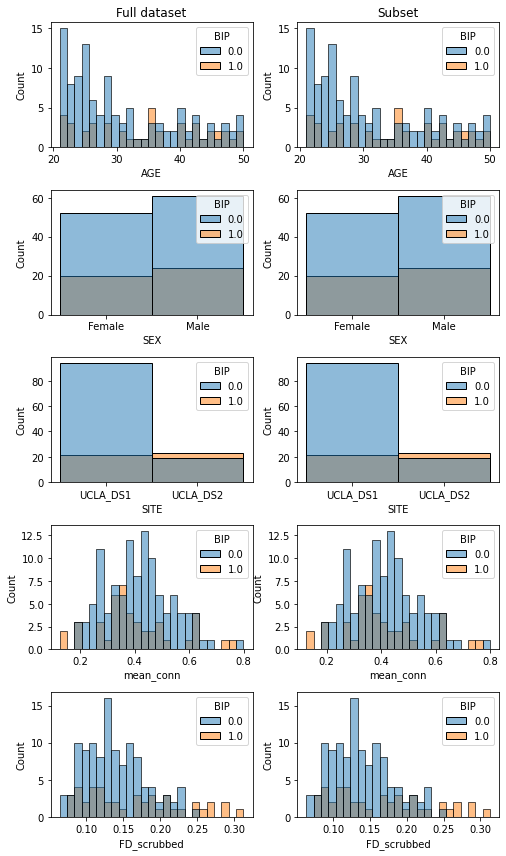

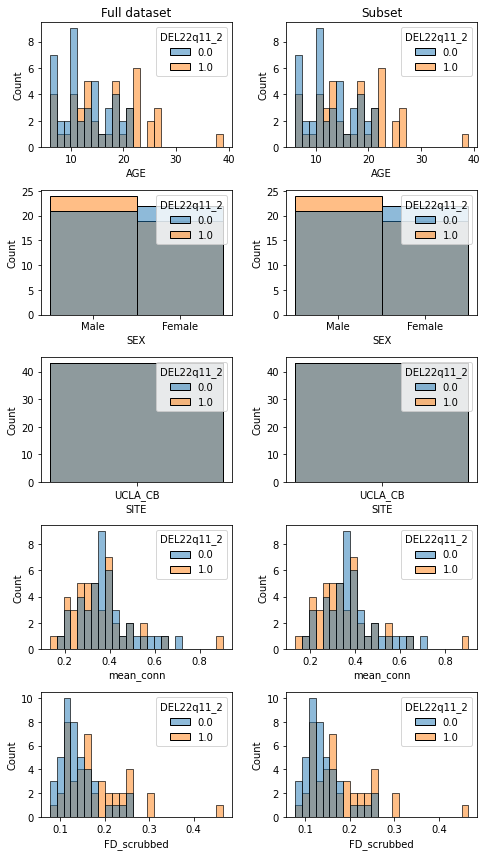

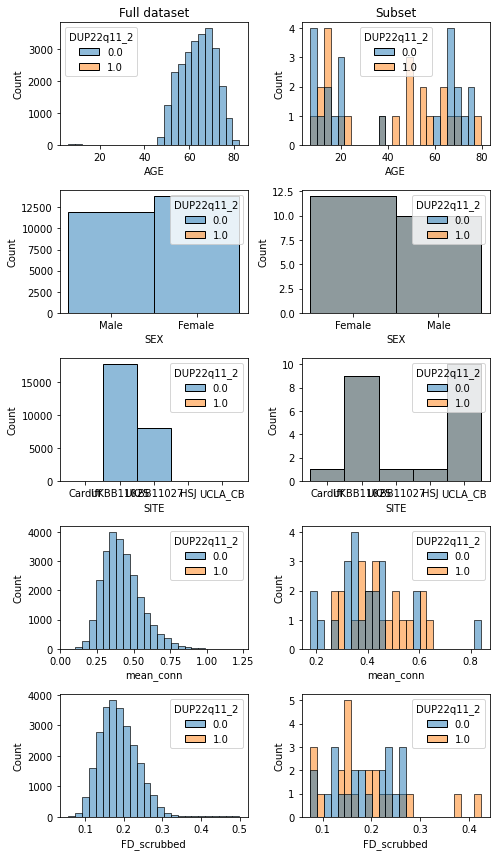

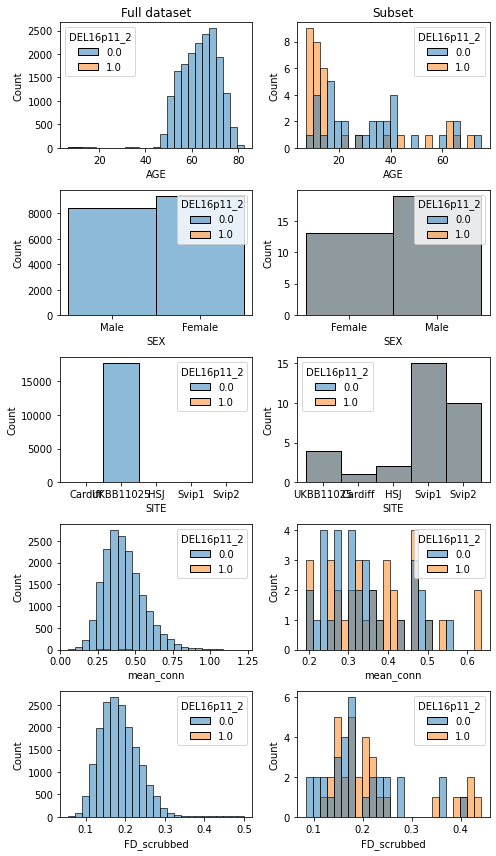

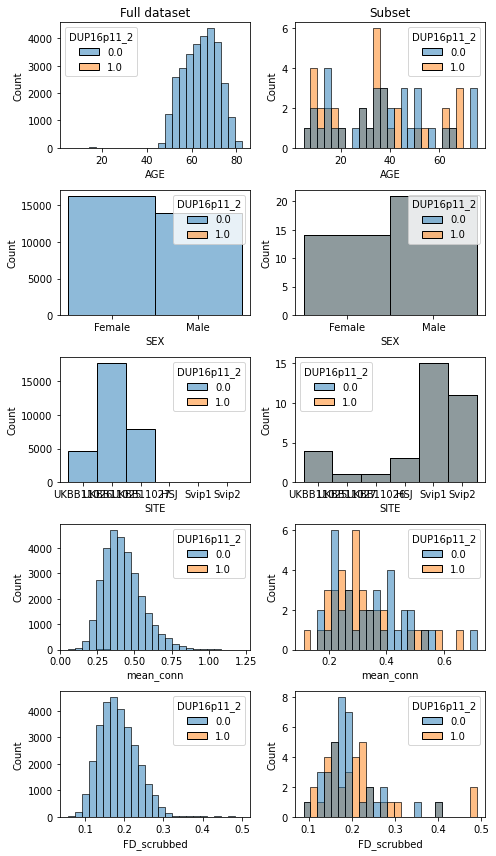

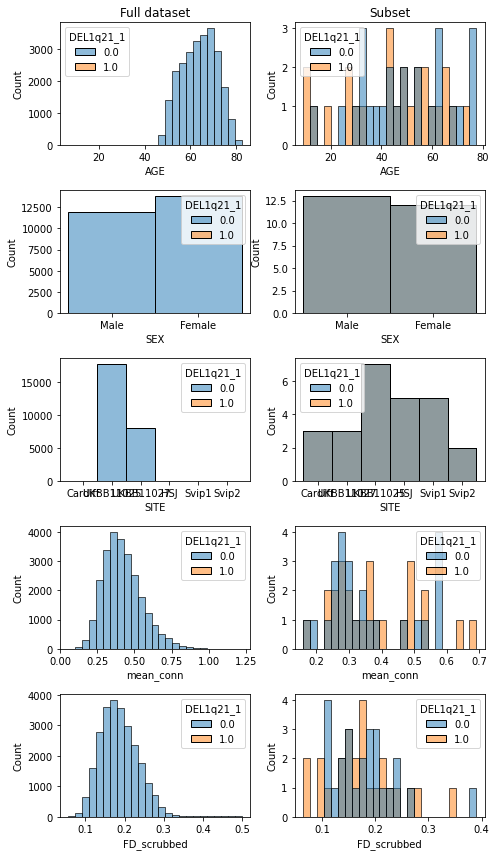

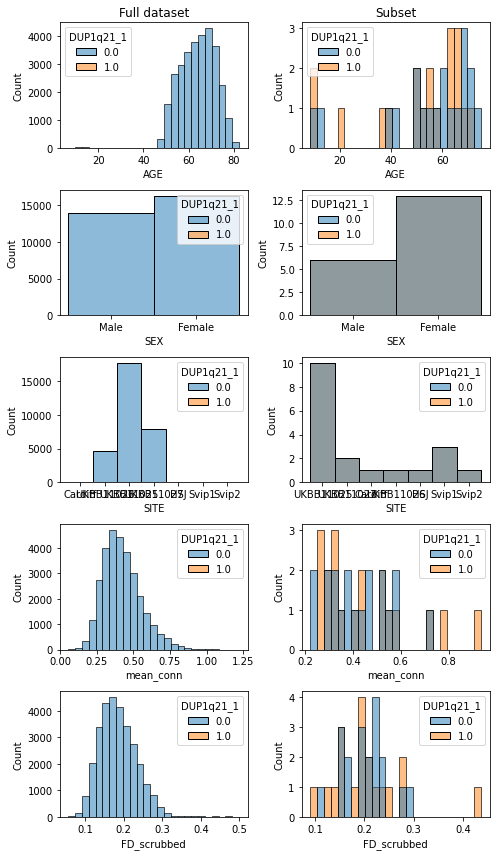

In [6]:
for case in cases:
        ids = sel_ids[case]
        
        control = 'CON_IPC' if case in ipc else 'non_carriers'
        
        sites = pheno[pheno[case]==1]['SITE'].unique()
        df = pheno[(pheno['SITE'].isin(sites))
                & ((pheno[case]==1)|(pheno[control]==1))]

        fig, ax = plt.subplots(len(conf),2,figsize=(7,12))

        for i,c in enumerate(conf):
                sns.histplot(x=c,data=df,hue=case,bins=25,ax=ax[i,0])
                
                sns.histplot(x=c,data=df[df.index.isin(ids[0].to_list())],hue=case,bins=25,ax=ax[i,1])

                if i == 0:
                        ax[i,0].set_title('Full dataset')
                        ax[i,1].set_title('Subset')

        plt.tight_layout()

## Generate CV splits
For each case, generate 5 class balanced test sets (that are different from each other).

In [15]:
#def class_balance_small

def generate_cv_splits(case,ids,conf,pheno,path_out,plim=0.05, min_folds=5,force_save=False,min_train=0.5, min_members=2):
    print(case)
    control = 'CON_IPC' if case in ['ASD','BIP','SZ'] else 'non_carriers'

    df = pheno[pheno.index.isin(ids[0].to_list())]
    df.loc[:,case] = df.loc[:,case].astype(int)

    subsets = []
    fail_attempts = 0
    while len(subsets) != min_folds:
        print('Looking for a new split')
        confounds = df[conf].transpose().values
        classes = df[case].values.astype(int)
        
        train_size = 0
        ddd = df.copy()
        while train_size < min_train:
            selection = class_balance(classes,confounds,plim=plim,min_members=min_members)
            train_size =  1 - len(selection)/len(df)
            #print(train_size)
            if train_size < min_train:
                #print('subselecting...')
                classes = classes[selection]
                confounds = confounds[:,selection]
                ddd = ddd[selection]
        #print('found a split')

        selection = df.index.isin(ddd.index)
        fold_ids = df[selection].index.to_list()
        # if None so far append
        if len(subsets) == 0:
            subsets.append(fold_ids)
        # Otherwise check if duplcate with existing selections
        else:
            duplicate = []
            for subset in subsets:
                diff = set(subset).difference(set(fold_ids))
                duplicate.append(len(diff) == 0)
                
            if not np.any(duplicate):
                subsets.append(fold_ids)
            else:
                fail_attempts += 1
                #print('Duplicate!')
                
            if fail_attempts > 50:
                print('Failed!')
                break

    print('N subsets: ',len(subsets))
    
    if (len(subsets) == min_folds) | force_save:
        print('Saving fold ids...\n')
        for i in range(len(subsets)):
            save_ids(subsets[i],path_out,case,i)

In [16]:
conf = ['AGE',
        'SEX',
        'SITE',
        'mean_conn',
        'FD_scrubbed']

cases = ['SZ',
        'ASD',
        'BIP',
        'DEL22q11_2',
        'DUP22q11_2',
        'DEL16p11_2',
        'DUP16p11_2',
        'DEL1q21_1',
        'DUP1q21_1'
        ]

plim = 0.05
min_train = 0.7

cv_ids = []
for case in cases:
    generate_cv_splits(case,
    sel_ids[case],
    conf,
    pheno,
    p_out,
    plim=plim,
    force_save=False,
    min_train=min_train)

SZ
Looking for a new split
Looking for a new split
Looking for a new split
Looking for a new split
Looking for a new split
N subsets:  5
Saving fold ids...

ASD
Looking for a new split
Looking for a new split
Looking for a new split
Looking for a new split
Looking for a new split
N subsets:  5
Saving fold ids...

BIP
Looking for a new split
Looking for a new split
Looking for a new split
Looking for a new split
Looking for a new split
N subsets:  5
Saving fold ids...

DEL22q11_2
Looking for a new split
Looking for a new split
Looking for a new split
Looking for a new split
Looking for a new split
N subsets:  5
Saving fold ids...

DUP22q11_2
Looking for a new split
Looking for a new split
Looking for a new split
Looking for a new split
Looking for a new split
N subsets:  5
Saving fold ids...

DEL16p11_2
Looking for a new split
Looking for a new split
Looking for a new split
Looking for a new split
Looking for a new split
N subsets:  5
Saving fold ids...

DUP16p11_2
Looking for a new spl

## Check splits

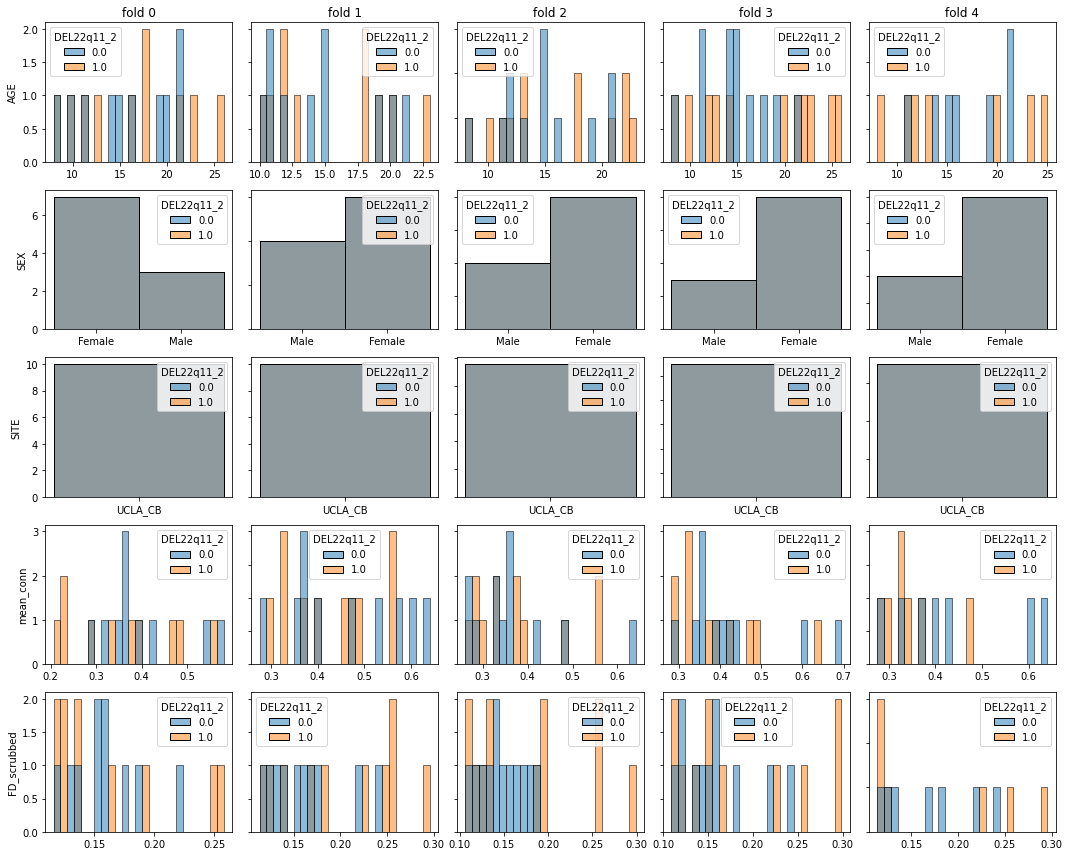

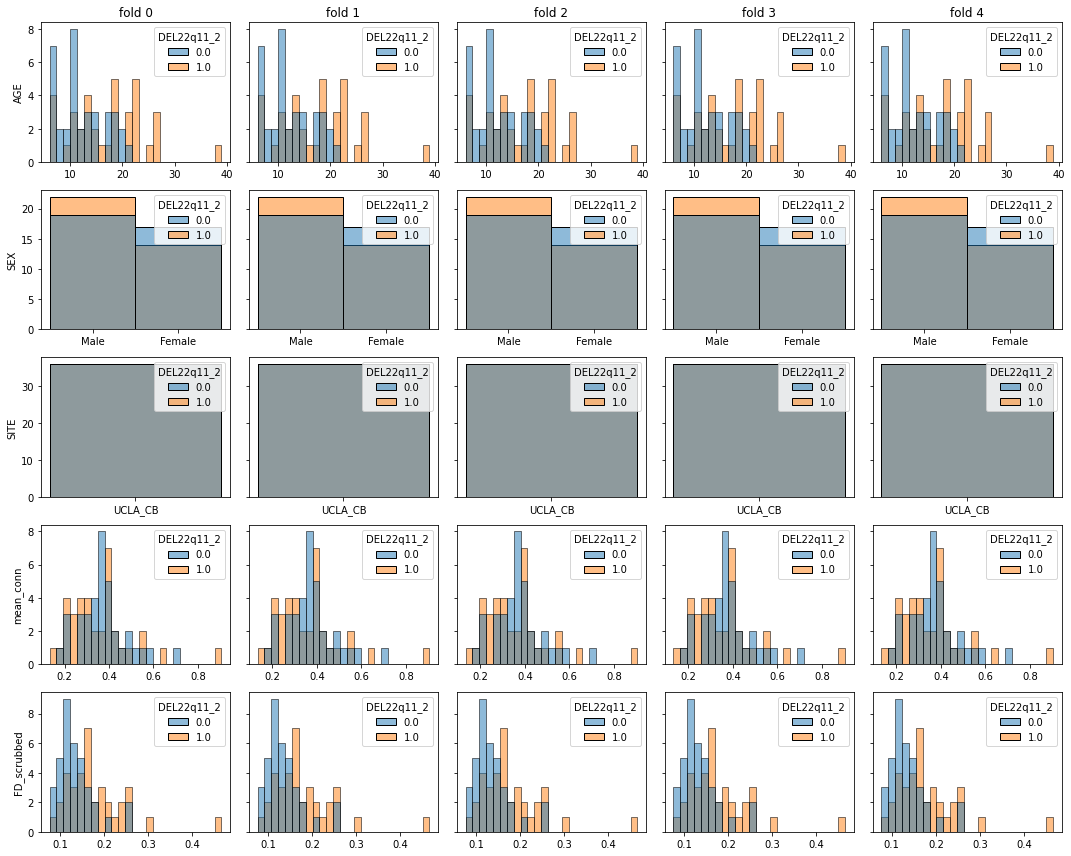

In [37]:
cases = ['SZ',
        'ASD',
        'BIP',
        'DEL22q11_2',
        'DUP22q11_2',
        'DEL16p11_2',
        'DUP16p11_2',
        'DEL1q21_1',
        'DUP1q21_1']

case = 'DEL22q11_2'
#for case in cases:

all_ids = pd.read_csv(os.path.join(p_ids,f"{case}.txt"),header=None)
# PLOT TEST SET
fig, ax = plt.subplots(len(conf),5,figsize=(15,12))
for i,c in enumerate(conf):
        for fold in range(5):
                ids = pd.read_csv(os.path.join(p_out,f"{case}_test_set_{fold}.txt"),header=None)
                
                sns.histplot(x=c,data=pheno[pheno.index.isin(ids[0].to_list())],hue=case,bins=25,ax=ax[i,fold])
                if i == 0:
                        ax[i,fold].set_title(f'fold {fold}')
                if fold == 0:
                        ax[i,fold].set_xlabel('')
                        ax[i,fold].set_ylabel(c)
                else:
                        ax[i,fold].set_xlabel('')
                        ax[i,fold].set_ylabel('')
                        ax[i,fold].set_yticklabels([])
plt.tight_layout()
plt.subplots_adjust(wspace=0.1,hspace=0.2)
plt.show()

# PLOT TRAIN SET
fig, ax = plt.subplots(len(conf),5,figsize=(15,12))
for i,c in enumerate(conf):
        for fold in range(5):
                ids_train = list(set(all_ids[0].to_list()).difference(set(ids[0].to_list())))
                
                sns.histplot(x=c,data=pheno[pheno.index.isin(ids_train)],hue=case,bins=25,ax=ax[i,fold])
                if i == 0:
                        ax[i,fold].set_title(f'fold {fold}')
                if fold == 0:
                        ax[i,fold].set_xlabel('')
                        ax[i,fold].set_ylabel(c)
                else:
                        ax[i,fold].set_xlabel('')
                        ax[i,fold].set_ylabel('')
                        ax[i,fold].set_yticklabels([])
plt.tight_layout()
plt.subplots_adjust(wspace=0.1,hspace=0.2)
plt.show()

## Clean up .txt -> .csv

In [47]:
cases = ['SZ',
        'BIP',
        'ASD',
        'DEL22q11_2',
        'DEL16p11_2',
        'DUP16p11_2',
        'DUP22q11_2',
        'DEL1q21_1',
        'DUP1q21_1'
        ]
        
p_ids = '/home/harveyaa/Documents/masters/MTL/conf_balancing/dataset_ids/'
p_out = '/home/harveyaa/Documents/masters/MTL/conf_balancing/dataset_ids_temp/'
tag = '{}.txt'
tag_split = '{}_test_set_{}.txt'

dfs = []
for case in cases:
    dataset_ids = pd.read_csv(os.path.join(p_ids,tag.format(case)),header=None)
    dataset_ids.set_index(0,inplace=True)

    for i in range(5):
        p_split_ids = os.path.join(p_out,tag_split.format(case,i))
        if os.path.exists(p_split_ids):
            s_ids = pd.read_csv(p_split_ids,header=None)
            dataset_ids[f'fold_{i}'] = 1*dataset_ids.index.isin(s_ids[0].to_list())

    dataset_ids[case] = pheno[pheno.index.isin(dataset_ids.index)][case].values.astype(int)
    dataset_ids.to_csv(os.path.join(p_ids,f"{case}.csv"))
    dfs.append(dataset_ids)

In [48]:
for df in dfs:
    print(df.columns[-1])
    train_sizes = []
    for i in range(5):
        if f'fold_{i}' in df.columns:
            ts = 1-df[f'fold_{i}'].sum()/len(df)
            train_sizes.append(ts)
    print('Avg train %: ',np.mean(train_sizes))
    

SZ
Train %:  0.7021943573667712
Train %:  0.7053291536050157
Train %:  0.7021943573667712
Train %:  0.7021943573667712
Train %:  0.7429467084639498
BIP
Train %:  0.7324840764331211
Train %:  0.7452229299363058
Train %:  0.7197452229299364
Train %:  0.7197452229299364
Train %:  0.7452229299363058
ASD
Train %:  0.7009544008483564
Train %:  0.7030752916224814
Train %:  0.7030752916224814
Train %:  0.7030752916224814
Train %:  0.7009544008483564
DEL22q11_2
Train %:  0.7674418604651163
Train %:  0.7674418604651163
Train %:  0.7209302325581395
Train %:  0.7441860465116279
Train %:  0.8372093023255813
DEL16p11_2
Train %:  0.78125
Train %:  0.75
Train %:  0.71875
Train %:  0.78125
Train %:  0.75
DUP16p11_2
Train %:  0.7142857142857143
Train %:  0.7142857142857143
Train %:  0.7714285714285715
Train %:  0.7428571428571429
Train %:  0.7428571428571429
DUP22q11_2
Train %:  0.7272727272727273
Train %:  0.7727272727272727
Train %:  0.7727272727272727
Train %:  0.7272727272727273
Train %:  0.72727272

In [43]:
dfs

[               SZ
 0                
 sub_10159       0
 sub_10171       0
 sub_10189       0
 sub_10206       0
 sub_10217       0
 ...            ..
 szipraPM34MM    1
 szipraPM35DW2   1
 szipraPM36GD    1
 szipraPM38SD    1
 szipraPM41MB    1
 
 [638 rows x 1 columns],
            BIP
 0             
 sub_10159    0
 sub_10171    0
 sub_10189    0
 sub_10206    0
 sub_10217    0
 ...        ...
 sub_60079    1
 sub_60080    1
 sub_60084    1
 sub_60087    1
 sub_60089    1
 
 [157 rows x 1 columns],
             ASD
 0              
 s50103        0
 s50104        0
 s50106        0
 s50108        0
 s50109        0
 ...         ...
 sub0030239    0
 sub0030245    1
 sub0030247    0
 sub0030248    0
 sub0030251    0
 
 [943 rows x 1 columns],
                  DEL22q11_2
 0                          
 Qx0020x05052011           1
 Qx0036x03302010           1
 Qx0037x04202011           1
 Qx0039x06012011           1
 Qx0051x01302012           1
 ...                     ...
 Qx0252x121